# Телеком. Введение

Оператор связи хочет внедрить модель которая поможет предсказывать разорвёт ли абонент договор. Идея в том чтобы таким пользователям предлагать промокоды и различные специальные условия в надежде удержать клиентов от расторжения договора. Нам предоставили доступ к данным о некоторых клиентах. Используя эти данные мы должны обучить модель для прогноза оттока клиентов.

Изучим данные. Они находять в базе данных PostgreSQL, поключимся к ней, сделаем анализ, извлечём необходимые данные и сделаем обработку при необходимости.

После получения данных, произведём их подготовку для моделей машинного обучения. Получим выборки для обучения и тестирования. Будем рассматривать несколько типов моделей таких как: классические, бустинг, нейронная сеть. Нас интересует метрика ROC-AUC, которая должная быть не менее 0.85 чтобы мы могли считать модель успешной.

# Содержание

- [Первичное изучение данных](#exploration)
  - [Выводы по первичному изучению](#exploration_conclusion)
- [Предобработка и исследовательский анализ](#preprocessing_eda)
  - [Таблица contact](#contact)
  - [Таблица personal](#personal)
  - [Таблица internet](#internet)
  - [Таблица phone](#phone)
  - [Выводы по исследованию таблиц](#tables_conclusion)
  - [Объединение таблиц и добавление данных](#new_tables)
  - [Визуализации признаков](#visual)
  - [Выводы по предобработке и анализу](#visual_conclusion)
- [Работа с моделями](#models)
  - [Подготовка признаков](#features)
  - [Dummy Classifier](#dummy)
  - [Случайный лес](#rf)
  - [Catboost](#catboost)
  - [Нейронная сеть](#net)
  - [Выводы по обучению моделей](#models_conclusion)
- [Тестирование модели](#test)
- [Выводы](#conclusion)

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

from sqlalchemy import create_engine, inspect

**Пропишем константу для фиксирования состояния случайных величин**

In [2]:
RANDOM_STATE = 131123

**Изменим несколько параметров pandas**

In [3]:
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', 50)

<a id='exploration'></a>
## Первичное изучение данных

**Данные для поключения к базе данных**

**!!! Данные которые использовались для подключения к базе заменены на заглушки: user, password и тд. !!!**

In [4]:
db_config = {
'user': 'user',
'pwd': 'password',
'host': 'host',
'port': 1111,
'db': 'db'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

**Подключимся к базе**

In [5]:
engine = create_engine(connection_string)

К базе подключились, теперь посмотрим какие там есть схемы.

In [6]:
inspector = inspect(engine)

In [7]:
schemas = inspector.get_schema_names()
print(schemas)

['information_schema', 'public', 'steel', 'telecom']


Нас интересует схема telecom, посмотрим на таблицы в ней.

In [8]:
inspector.get_table_names(schema=schemas[3])

['contract', 'internet', 'personal', 'phone']

Нашли 4 таблицы. Количество и их названия соответсвуют описанию которое предоставил заказчик.

**Извлечём таблицы в датафреймы**

In [9]:
query = '''
SELECT *
FROM telecom.contract;
'''

contract = pd.read_sql_query(query, con=engine)

In [10]:
query = '''
SELECT *
FROM telecom.personal;
'''

personal = pd.read_sql_query(query, con=engine)

In [11]:
query = '''
SELECT *
FROM telecom.internet;
'''

internet = pd.read_sql_query(query, con=engine)

In [12]:
query = '''
SELECT *
FROM telecom.phone;
'''

phone = pd.read_sql_query(query, con=engine)

Датафремы получили, изучим их.

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


В таблице `contract` 7043 строки и 8 стобцов. Количество стобцов и их названия корректные, но BeginDate и EndDate имеют неправильный тип данных, в дальнейшем исправим это.

In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В таблице `personal` 7043 строки и 8 стобцов. Количество стобцов и их названия корректные.

In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [18]:
internet.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


В таблице `internet` 5518 строк и 8 стобцов. Количество стобцов совпадает, а вот имена нет. Корректные имена оказались в первой строке. Это значит что по факту у нас 5517 строк в данной таблице. В дальнейшем изменим названия стобцов на корректные.

In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
phone.head(5)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


В таблице `phone` 6362 строки и 2 стобца. Так же как и в таблице `internet` количество стобцов совпадает, а названия находятся в первой строке. Названия исправим в дальнейшем.

<a id='exploration_conclusion'></a>
### Выводы по первичному изучению данных

Извлекли 4 таблицы из базы в датафреймы. Больше всего данных находится в двух таблицах `contract` и `personal`, в каждом их них 7043 строки. В двух других таблицах строк меньше, можем сделать вывод что есть абоненты которые пользуются только услугами стационарной телефонной связи без интернета, а так же наоборот - интернет без телефонной связи. В таблицах присутсвёт неправильные типы данных стобцов, а так же некорректные их названия. Таблицы `internet` и `phone` в первой строке ошибочно содержат названия стобцов.

Так как данных немного, они не будут динамично обновлятся и работать нам ними не приходится в команде, мы можем использовать датафреймы которые мы получили, для дальнейшего анализа вместо запросов в базу данных.

<a id='preprocessing_eda'></a>
## Предобработка и исследовательский анализ

Ранее мы выяснили что в двух таблицах некоректные названия столбцов, сразу исправим это.

In [21]:
internet_column_names = internet.iloc[0].tolist()
internet.columns = internet_column_names
internet = internet.iloc[1:].reset_index(drop=True)

In [22]:
phone_column_names = phone.iloc[0].tolist()
phone.columns = phone_column_names
phone = phone.iloc[1:].reset_index(drop=True)

In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [26]:
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Название исправили, теперь все таблицы имеют корректные названия стобцов.

<a id='contact'></a>
### Таблица `contract`

В `contract` нужно скорректировать столбцы BeginDate и EndDate, они содержат даты.

In [27]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d %H:%M:%S')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

In [28]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Столбцы с датами исправили. У нас есть два стобца с типом float64, возможно можно их изменить для экономия памяти. Сначала нужно посмотреть какие они содержат значения.

In [29]:
contract.describe()

,MonthlyCharges,TotalCharges
count,"7,043.00","7,032.00"
mean,64.76,"2,283.30"
std,30.09,"2,266.77"
min,18.25,18.80
25%,35.50,401.45
50%,70.35,"1,397.47"
75%,89.85,"3,794.74"
max,118.75,"8,684.80"


Можем изменить тип на float32.

In [30]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype('float32')
contract['TotalCharges'] = contract['TotalCharges'].astype('float32')

In [31]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float32       
 7   TotalCharges      7032 non-null   float32       
dtypes: datetime64[ns](2), float32(2), object(4)
memory usage: 385.3+ KB


Типы исправили. Узнали что в расходах за месяц значения находятся в диапазоне от 18.25 до 118.75, а общие расходы - от 18.8 до 8684.8. Посмотрим внимательнее на распределение.

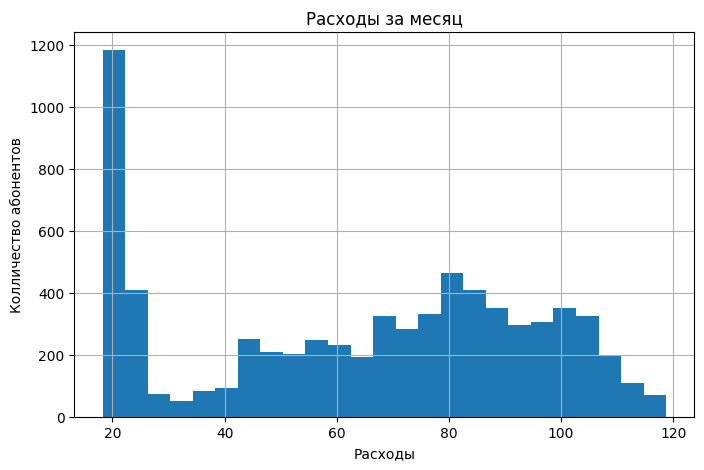

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(contract['MonthlyCharges'], bins=25)
plt.title("Расходы за месяц")
plt.xlabel("Расходы")
plt.ylabel("Колличество абонентов")
plt.grid(True)
plt.show()

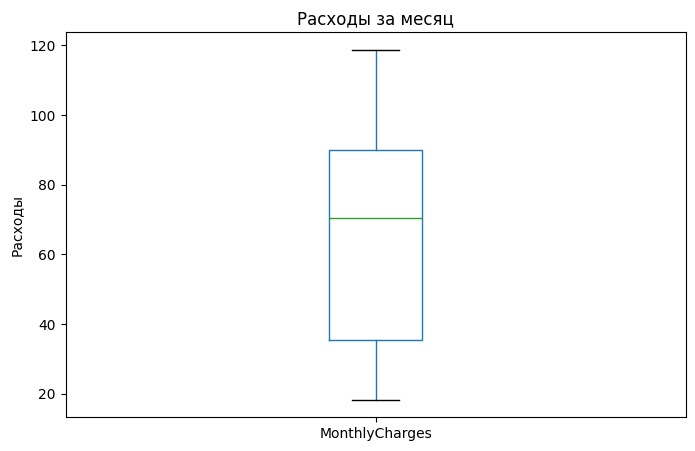

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
contract['MonthlyCharges'].plot(kind='box');
ax.set_title('Расходы за месяц')
ax.set_ylabel('Расходы')
plt.show()

Видим что в расходах за месяц большое колличество значений приходится на диапазон 18-35, потом идёт разкий спад и далее наблюдается небольшой рост который выходит на пик в районе 80. Среднее значение он медианы не сильно отличается 65 и 70 соответсвенно. Выбросы отсутсвуют, пропуски тоже, распределение можем назвать бимодальным оно имеют логику для этой колонки. Скорей всего первый пик приходится на абонентов которые пользуются минимальными пакетами, а второй пик на тех кто пользуется популярным набором доп услуг, например какой-то не минимальный безлимитный тариф интернета и тд тп. Те кто в меньшую сторону от пиковых пользователей расположены пользуются меньшим колличеством услуг или более дешевымим их вариантами, а в большую - наоборот.

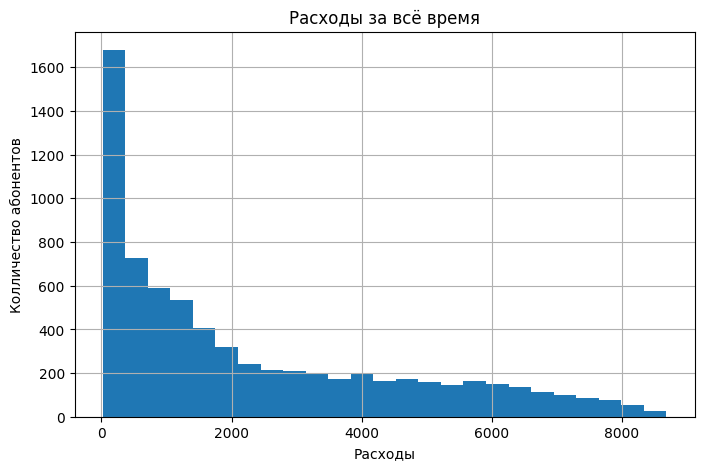

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(contract['TotalCharges'], bins=25)
plt.title("Расходы за всё время")
plt.xlabel("Расходы")
plt.ylabel("Колличество абонентов")
plt.grid(True)
plt.show()

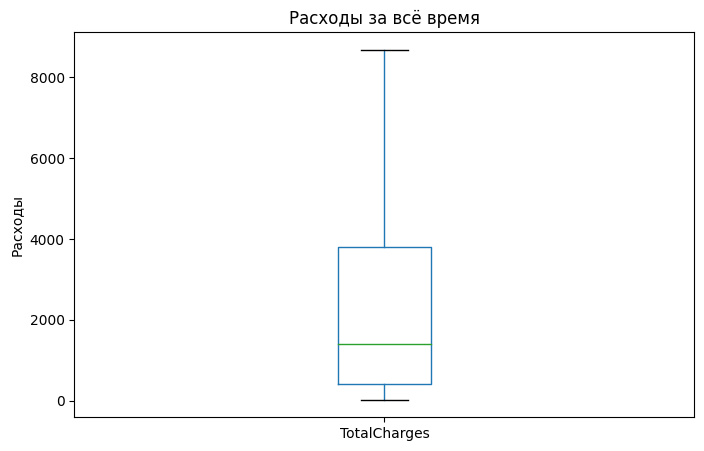

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
contract['TotalCharges'].plot(kind='box');
ax.set_title('Расходы за всё время')
ax.set_ylabel('Расходы')
plt.show()

Распределение расходов за всё время имеет длинный хвост вправо. Большая часть значений приходится на диапазон до 2000. Выбросов нет. Среднее значение 2283, а медиана 1398. Данная разница присутсвует из-за типа распределения. Распределение выглядит логично, аномалии отсутсвуют. Есть 11 пропусков, рассмотрим их.

In [36]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN


Во всех случаях начала действия договора 1 февраля 2020 года, что совпадает с датой актуальности предоставленных данных, то есть данный абоненты новые и расходы за всё время у них пока отсутсвуют. Заменим эти значения на 0.

In [37]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

In [38]:
contract['TotalCharges'].isna().sum()

0

Пропуски в TotalCharges обработали.

Посмотрим на PaymentMethod.

In [39]:
contract['PaymentMethod'].unique()

array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)

In [40]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Нашли 4 типа платежей. Все примерно одинаково распространены, Electronic check немного более популянее. Аномалии отсутсвуют.

Посмотрим на PaperlessBilling.

In [41]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [42]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Электронный расчётный лист более распространён. Аномалий нет.

Посмотрим на Type.

In [43]:
contract['Type'].unique()

array(['Two year', 'Month-to-month', 'One year'], dtype=object)

In [44]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Помесячная плата является самым распространённым типом оплаты. Годовая и двухгодовая имеют практически одинаковое колличество, немольшой уклон есть в сторону двухгодовой. Аномалий нет.

Посмотрим на EndDate.

In [45]:
contract['EndDate'].unique()

array([                          'NaT', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [46]:
contract['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

В EndDate есть только 4 даты окончания договора, а так же пропуски. Пропуски означают что абонент пользуется услугами. Используя эту колонку мы будем добавлять целевой признак, а так же возможно сгенерируем новые признаки. Пока пропуски оставим.

In [47]:
contract['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2019-03-20 03:51:02.274599168
min                2018-04-17 00:00:00
25%                2019-01-18 12:00:00
50%                2019-03-22 00:00:00
75%                2019-05-21 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

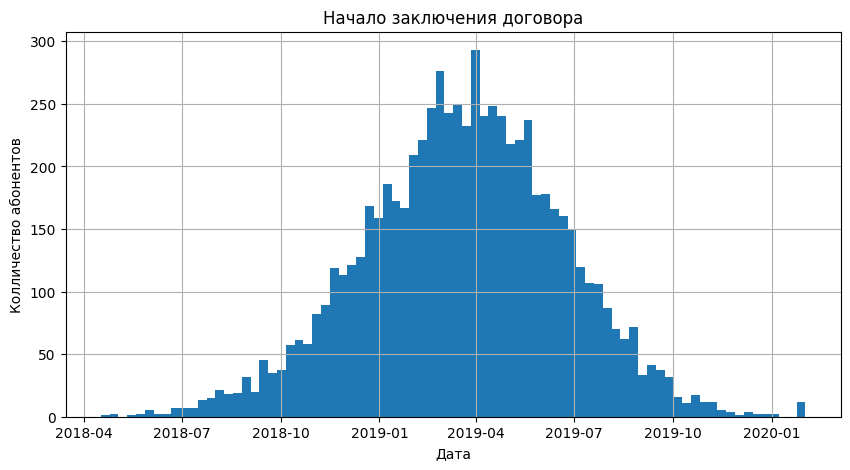

In [48]:
plt.figure(figsize=(10, 5))
plt.hist(contract['BeginDate'], bins=80)
plt.title("Начало заключения договора")
plt.xlabel("Дата")
plt.ylabel("Колличество абонентов")
plt.grid(True)
plt.show()

Больше 60% абонентов заключили договор в первые полгода 2019 года. Видим нормальное распределение с пиком в конце марта. Аномалии отсутсвуют.

In [49]:
contract['customerID'].nunique()

7043

In [50]:
contract.duplicated().sum()

0

Все индентификаторы пользователей униальны в таблице, дубликатов нет.

In [51]:
contract[contract['TotalCharges'] == contract['MonthlyCharges']]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
14,8779-QRDMV,2019-02-07,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65
15,1066-JKSGK,2019-05-03,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15
17,8665-UTDHZ,2019-07-28,2019-12-01,Month-to-month,No,Electronic check,30.20,30.20
27,5919-TMRGD,2019-05-09,2019-12-01,Month-to-month,Yes,Electronic check,79.35,79.35
39,3091-FYHKI,2019-01-19,2020-01-01,Month-to-month,Yes,Electronic check,35.45,35.45
...,...,...,...,...,...,...,...,...
6899,1724-IQWNM,2019-02-27,NaT,Month-to-month,Yes,Mailed check,19.30,19.30
6903,6127-IYJOZ,2019-04-21,NaT,Month-to-month,Yes,Mailed check,45.85,45.85
6946,9108-EJFJP,2019-04-05,NaT,Month-to-month,Yes,Mailed check,53.55,53.55
6997,5351-QESIO,2019-01-18,NaT,Month-to-month,No,Mailed check,24.20,24.20


<a id='personal'></a>
### Таблица `personal`

In [52]:
personal['customerID'].nunique()

7043

In [53]:
personal.duplicated().sum()

0

In [54]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Все индентификаторы пользователей униальны в таблице, дубликатов и пропусков нет.

Посмотрим на столбец gender.

In [55]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [56]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Пол пользователей распределем поровну. Мужчин на 67 больше, для данной выборки это незначительное число. Аномалий нет.

Посомтрим на SeniorCitizen.

In [57]:
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [58]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Большинство абонентов не являются пенсионерами. Аномалий нет. Изменим тип данных в стобце для экономии памяти.

In [59]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('int8')

Тип изменили.

Посмотрим на Partner.

In [60]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [61]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Значения распределены поровну, аномалии отсутсвуют.

Посомтрим на Dependents.

In [62]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [63]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

У большей части абонентов детей нет. Аномалй нет.

<a id='internet'></a>
### Таблица `internet`

In [64]:
internet['customerID'].nunique()

5517

In [65]:
internet.duplicated().sum()

0

In [66]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Все индентификаторы пользователей униальны в таблице, дубликатов и пропусков нет. Ранее мы выяснили что есть данные о 7043 пользователей, в данной таблице есть 5517 пользователей. То есть услугами связанными с интернетом пользуются 78% абонентов.

In [67]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [68]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Данные распределены между двумя типами подключения DSL и оптоволокно. Есть небольшой уклон в сторону оптоволокна. Аномалий нет.

Посмотрим на OnlineSecurity.

In [69]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [70]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Большая часть пользователей не пользуется услугами блокировки опасных сайтов, но есть немало тех кто пользуется данной услугой. Аномалий нет.

Посмотрим на OnlineBackup.

In [71]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [72]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Облачным хранилищем около 55% абонентов с интернет услугами не пользуются. Аномалий нет.

Посмотрим на DeviceProtection.

In [73]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [74]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

Услугам антивируса, как и облачным хранилищем пользуется около 45% пользователей интернет услуг. Аномалий нет.

Посмотрим на TechSupport.

In [75]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [76]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

63% пользователей интернет услуг не пользуются услугой выделейнной техподдержки. Аномалий нет.

Посмотрим на StreamingTV.

In [77]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [78]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

Данные распределены примерно поровну. Аномалий нет.

Посмотрим на StreamingMovies.

In [79]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

In [80]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Как и стриминговое телевидение, наблюдает равное распределение. Аномалий нет.

<a id='phone'></a>
### Таблица `phone`

In [81]:
phone['customerID'].nunique()

6361

In [82]:
phone.duplicated().sum()

0

In [83]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Все индентификаторы пользователей униальны в таблице, дубликатов и пропусков нет. В данной таблице 6361 пользователь. Количество абонентов которые пользуются стационарной телефонной связью больше чем интернетом.

In [84]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

In [85]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Около 53% пользователей стационарной телефонной связи не пользуются поключением к нескольким линиям одновременно. Аномалий нет.

<a id='tables_conclusion'></a>
### Выводы по индивидуальному исследованию таблиц

В таблице `contract` исправили неправильные типы данных в нескольких стобцах. В таблицах `internet` и `phone` заполнили названия стобцов корректными значениями.

- Таблица `contract` содержит данные о котрактах с абонентами, всего в таблице 7043 абонента. Изучив расходы за месяц выснили что есть два выраженных типа абонентов: те кто пользуется минимальными услугами и те кто каким-то популярными набором услуг в среднем сегменте. Обработали пропуски в общих расходах, определили что это новые пользователи и заменили пропуски на 0. Узнали что больше 60% абонентов заключили договор в первые полгода 2019 года, а данные о окончании договора есть за 4 даты: первые числа с ноября 2019 по январб 2020. Пропуски в столбце с окончанием договора означают что пользователь продолжает пользоваться услугами связи. Из этого стобца будем в дальнейшем выделять целевой признак, на данный момент пропуски тут не обрабатывали. Дубликатов и аномалий в таблице не обнаружили.

- Таблица `personal` содержит данные о пользователях, такие как семейное положение, наличие детей. Количество строк совпадает с данными о контрактах - 7043. В таблице нет пропусков, дубликатов и аномалий. Узнали что среди абонентов примерно одинаковое колличество мужчин и женщим, большинтво абонентов не являются пенсионерами, количество абонентов находящихся в браке распределено поровну и у большинства нет детей.

- Таблица `internet` содержит данные о тех абонентах которые пользуются услугами интернета, нашли 5517 таких пользователей. В таблице нет пропусков, дубликатов и аномалий. Абонентов использующих оптоволокно немного больше. Изучив данные по дополнительным услугам можем сделать вывод что около 55-60% предпочитают не пользоваться доп услугами, а просто подключают интернет.

- Таблица `phone` содержит данные о тех абонентах которые пользуются услугами стационарной телефонной связи, нашли 6361 пользователя. В таблице нет пропусков, дубликатов и аномалий. 53% не пользуется подключением к нескольким линиям.

<a id='new_tables'></a>
### Объединение таблиц и добавление данных

In [86]:
data = contract \
    .merge(personal, how='left', on='customerID') \
    .merge(internet, how='left', on='customerID') \
    .merge(phone, how='left', on='customerID') 

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float32       
 7   TotalCharges      7043 non-null   float32       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int8          
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Добавим столбец с 'премиальностью' интернет пользователей. 

- Если у клиента поключены все доп услуги будет значение - Premium.
- 1 или 2 услуги - Minimum.
- 3-5 услуг Above average.
- Нет доп услуг - Just internet.
- И для пользователей без интернета - No internet.

In [88]:
data['InternetLevel'] = data.apply(lambda row: 'Premium' if row['OnlineSecurity'] == 'Yes' and
                                                            row['OnlineBackup'] == 'Yes' and
                                                            row['DeviceProtection'] == 'Yes' and
                                                            row['TechSupport'] == 'Yes' and
                                                            row['StreamingTV'] == 'Yes' and
                                                            row['StreamingMovies'] == 'Yes'
                               
                                   else 'Minimum' if row[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].eq('Yes').sum() >= 1 and row[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].eq('Yes').sum() <= 2
                                   else 'Above average' if row[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].eq('Yes').sum() >= 3 and row[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].eq('Yes').sum() <= 5
                                   else 'Just internet' if row['InternetService'] == 'Yes'
                                   else 'No internet', axis=1)

data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,InternetLevel
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,Above average
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No internet
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Minimum
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,Above average
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,No internet


Столбец добавили, все доп услуги удалим, они нам теперь не понадобятся.

In [89]:
data = data.drop(['StreamingTV', 'StreamingMovies', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'], axis=1).reset_index(drop=True)

Таблицы объединили. Пропуски в стобцах из таблиц `internet` и `phone` означают что у абонента не подключены эти услуги, заполним пропуски заначением No, но сначала добавим несколько новых стобцов. Создадим столбец с пользователями стационарной связи, для интерента нам не понадобится отдельный стобец, в `InternetService` мы заполним значением 'No' для тех у кого он не поключен.

In [90]:
data.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,InternetLevel
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,NaN,Above average
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,NaN,No,No internet
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,No,Minimum
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,No,Above average
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No internet


In [91]:
data['Phone'] = data['MultipleLines'].apply(lambda x: 'Yes' if pd.notnull(x) else 'No')

In [92]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,InternetLevel,Phone
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,NaN,Above average,No
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,NaN,No,No internet,Yes
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,No,Minimum,Yes
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,No,Above average,Yes
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No internet,Yes


Заполним пропуски в колонках, пропуски значат что услуга не поключена.

In [93]:
data.loc[:, data.columns != 'EndDate'] = data.loc[:, data.columns != 'EndDate'].fillna('No Service')

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float32       
 7   TotalCharges      7043 non-null   float32       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int8          
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  MultipleLines     7043 non-null   object        
 14  InternetLevel     7043 n

Пропуски обработали, остались только в EndDate. Создадим стобец **Churn** содержащий целевой признак. Если клиент разорвал договор то значение будет "1" если продолжает пользоваться услугами - "0".

In [95]:
data['Churn'] = (np.where(data['EndDate'].isnull(), 0, 1)).astype('int8')

In [96]:
data.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,InternetLevel,Phone,Churn
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,No Service,Above average,No,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,No Service,No,No internet,Yes,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,No,Minimum,Yes,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,No,Above average,Yes,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No internet,Yes,1


Датами мы не будем пользоваться для обучения моделей, **BeginDate** и **EndDate** можем удалить.

In [97]:
data = data.drop(['BeginDate', 'EndDate'], axis=1).reset_index(drop=True)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float32
 5   TotalCharges      7043 non-null   float32
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int8   
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  MultipleLines     7043 non-null   object 
 12  InternetLevel     7043 non-null   object 
 13  Phone             7043 non-null   object 
 14  Churn             7043 non-null   int8   
dtypes: float32(2), int8(2), object(11)
memory usage: 674.2+ KB


Стобцы с датами удалили. Изменим тип в **SeniorCitizen** на obeject, они заполнены 0 и 1, в данном случае это категориальная переменная.

In [99]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)

In [101]:
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,InternetLevel,Phone,Churn
0,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,No Service,Above average,No,0
1,3115-CZMZD,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,No Service,No,No internet,Yes,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,No,Minimum,Yes,1
3,5709-LVOEQ,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,No,Above average,Yes,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No internet,Yes,1


<a id='visual'></a>
### Визуализации признаков

Визуализируем распределение признаков. Для начала посмотрим на баланс классов целевого признака.

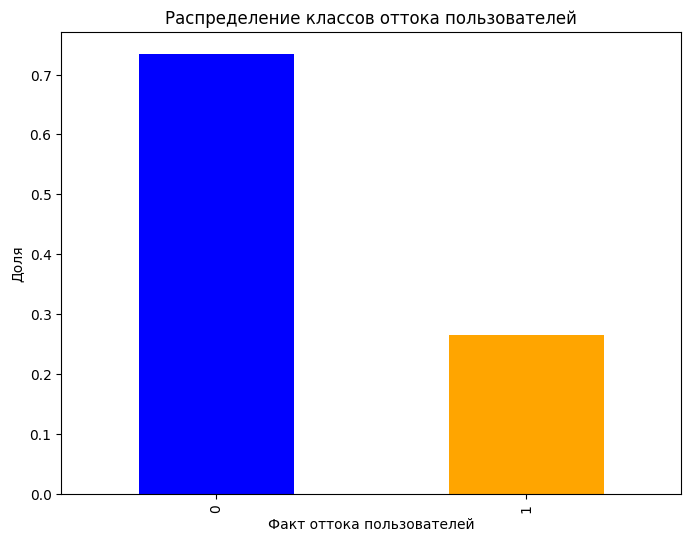

0   0.73
1   0.27
Name: Churn, dtype: float64


In [102]:
class_frequency = data['Churn'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
class_frequency.plot(kind='bar', color=['blue', 'orange'])

plt.title('Распределение классов оттока пользователей')
plt.xlabel('Факт оттока пользователей')
plt.ylabel('Доля')

plt.show()
print(class_frequency)

Присутсвует дисбаланс целевого признака. 27% абонентов разорвали договор.

Распределение числовых признаков мы делали во время изучения таблиц. Визуализируем распределение категориальных признаков.

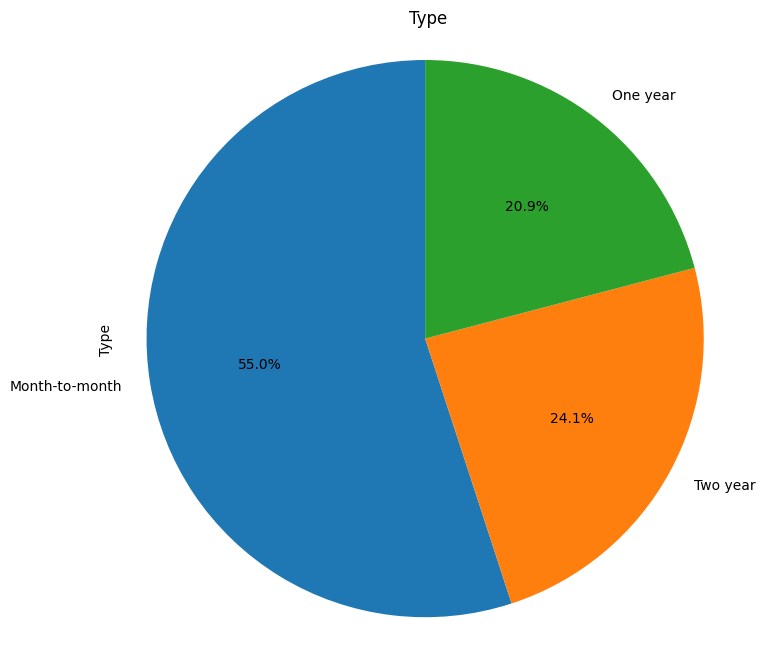

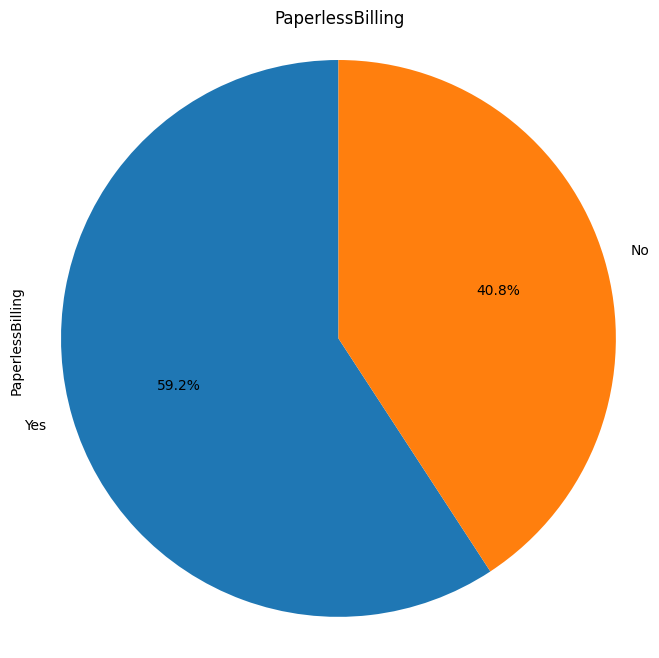

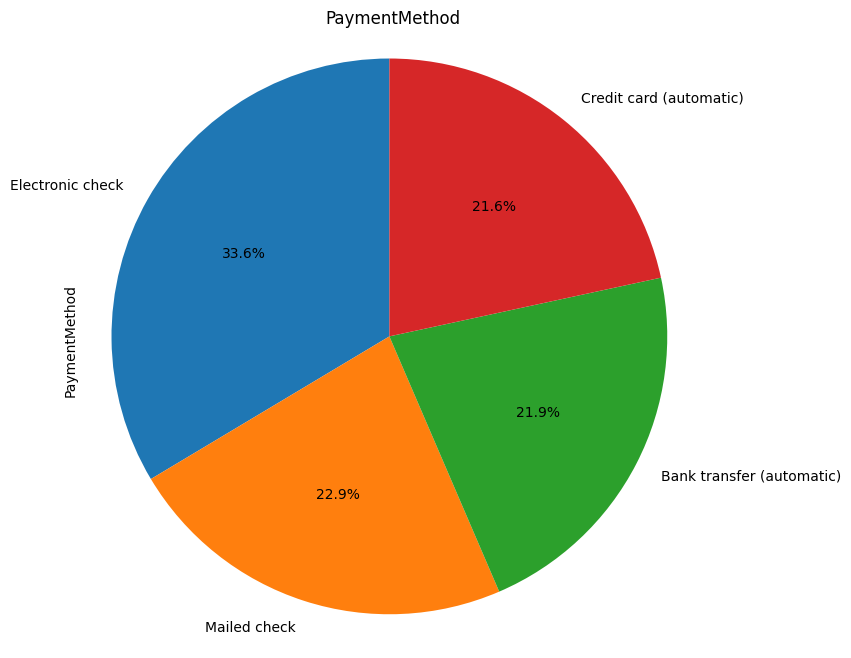

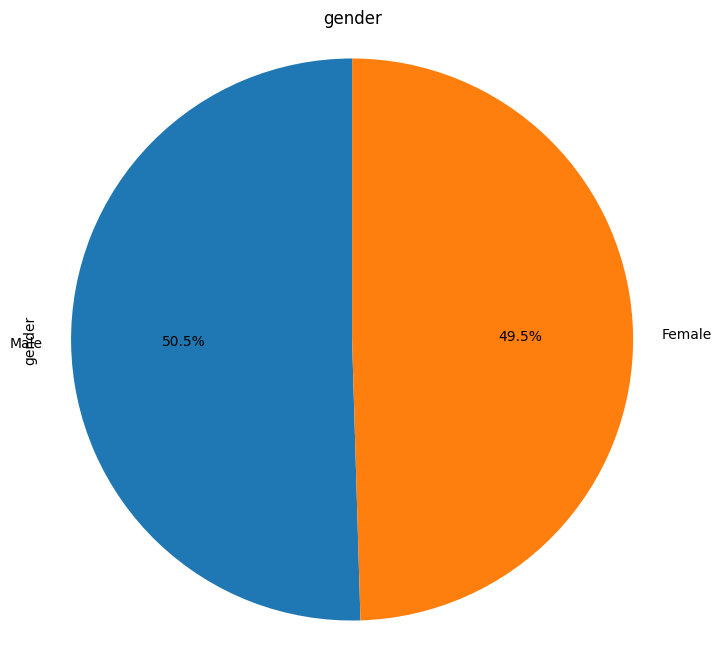

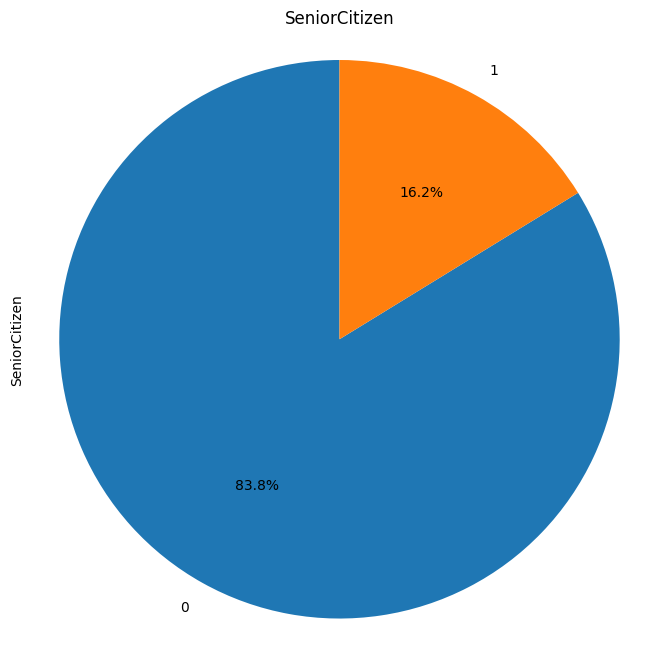

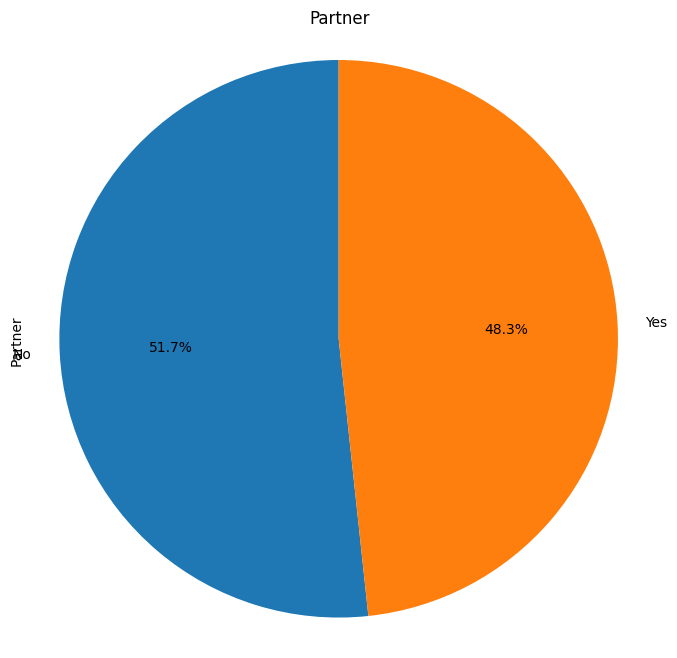

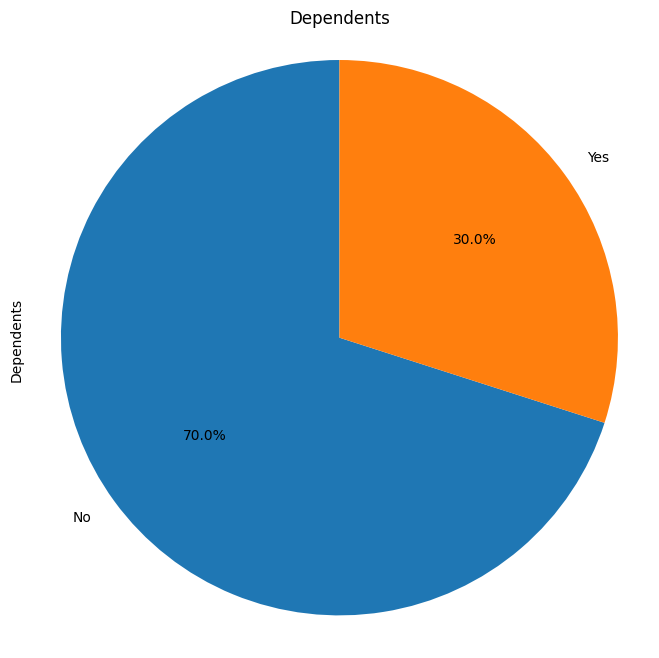

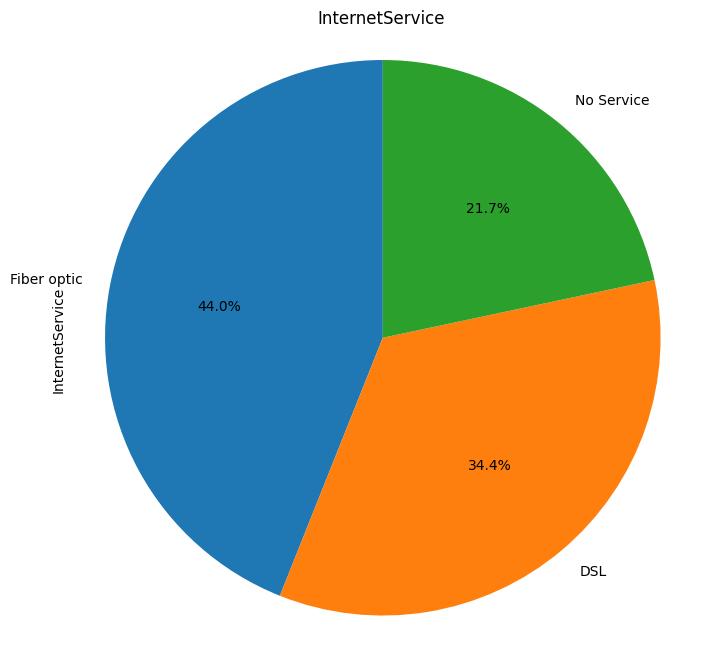

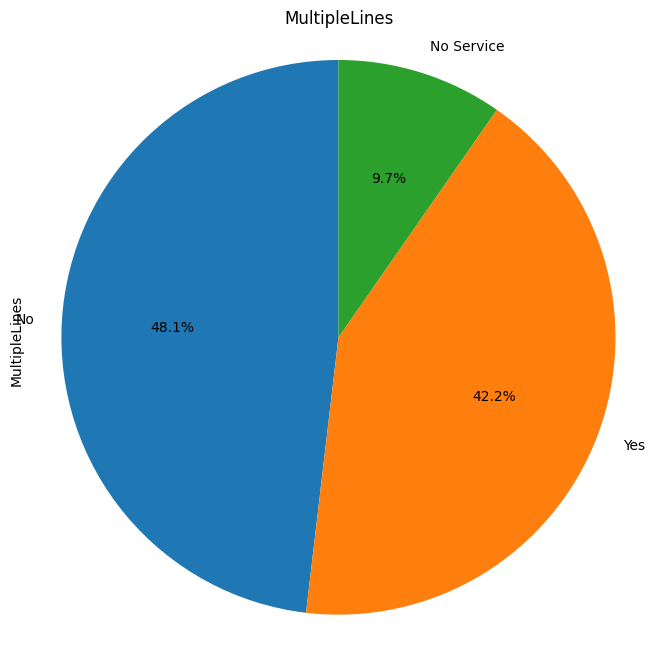

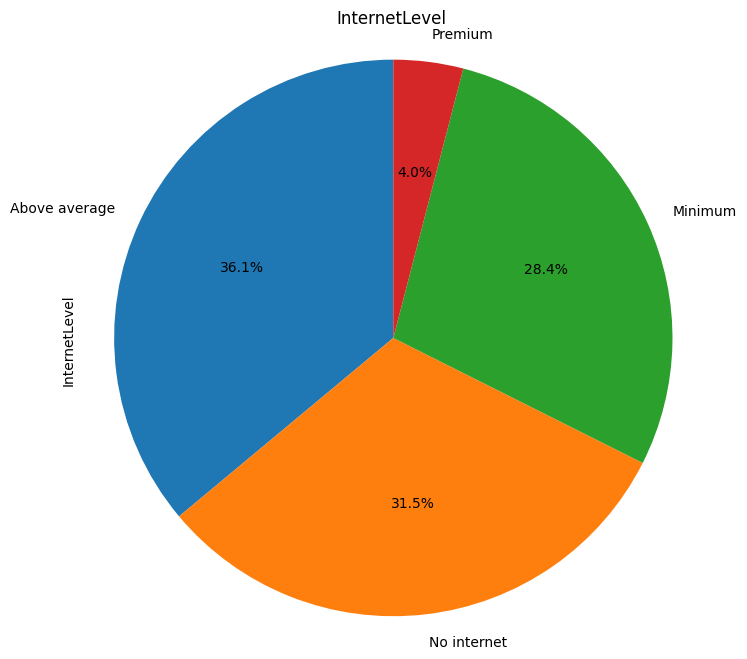

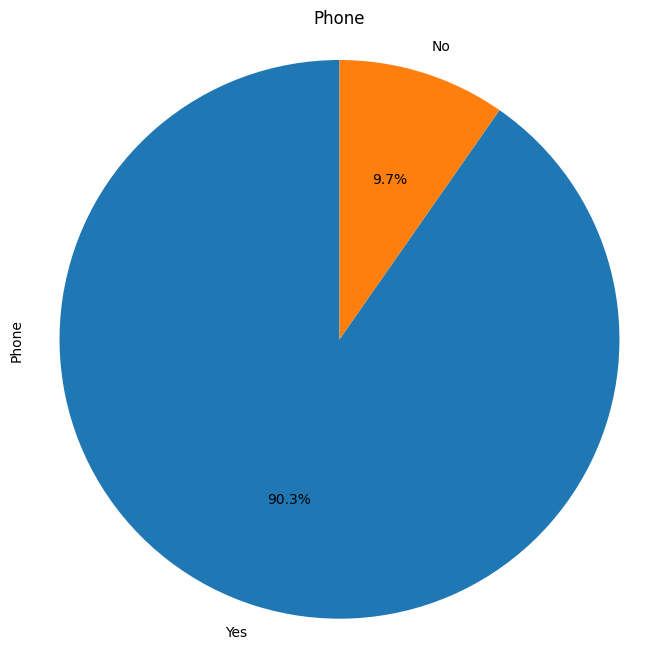

In [103]:
categorical_features = data.select_dtypes(include=['object']).columns

for feature in categorical_features:
    if feature != 'customerID':
        plt.figure(figsize=(8, 8))
        data[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title(feature)
        plt.axis('equal')
        plt.show()

Визуализации подтверждаю все выводы которые мы сделали при изучении таблиц.

Визуализируем соотношение ушедших и оставшихся клиентов для признаков.

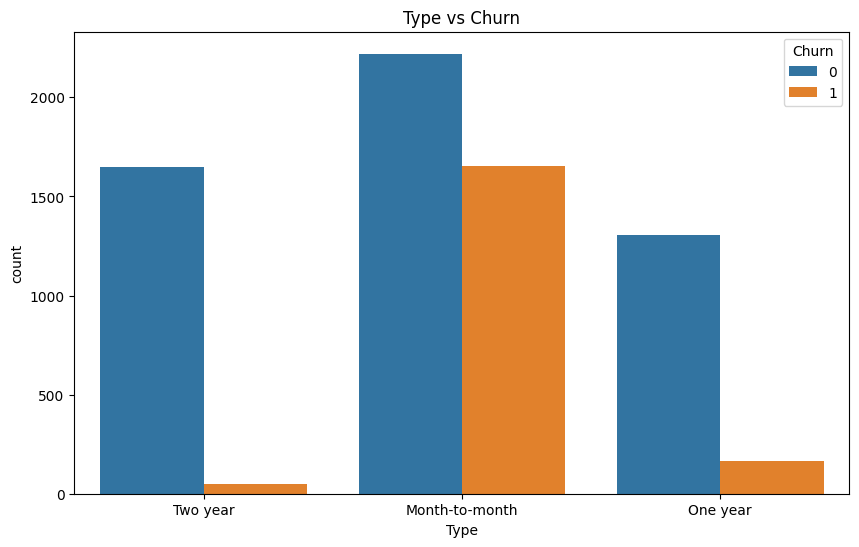

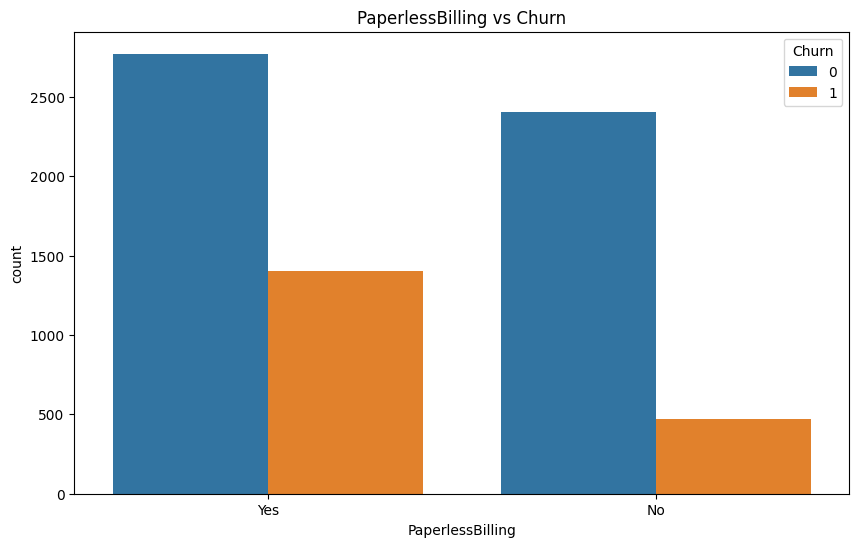

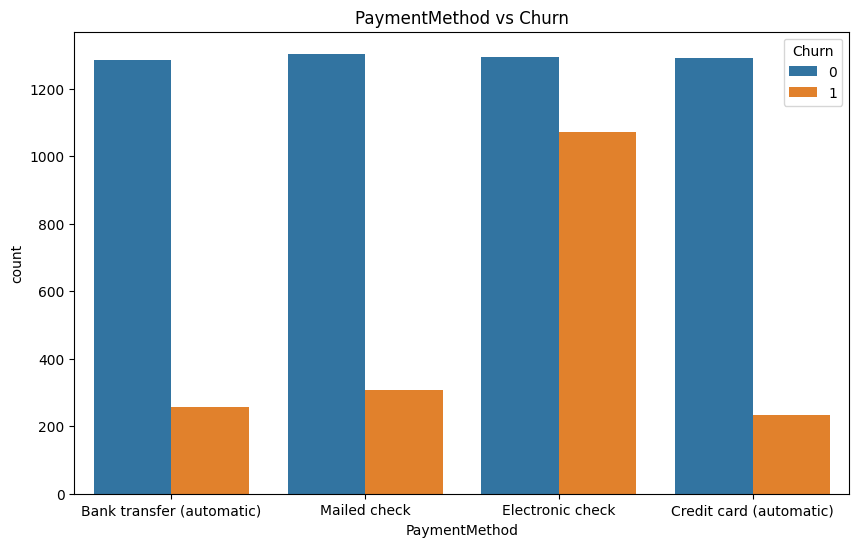

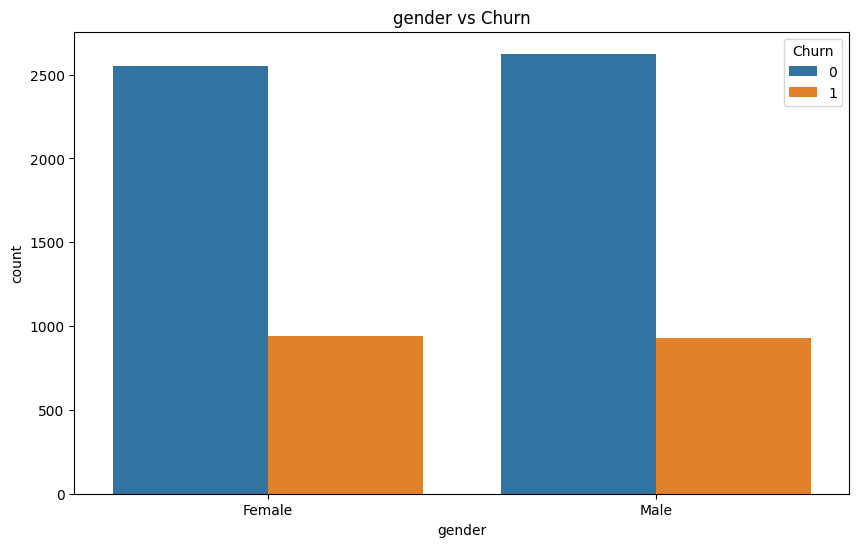

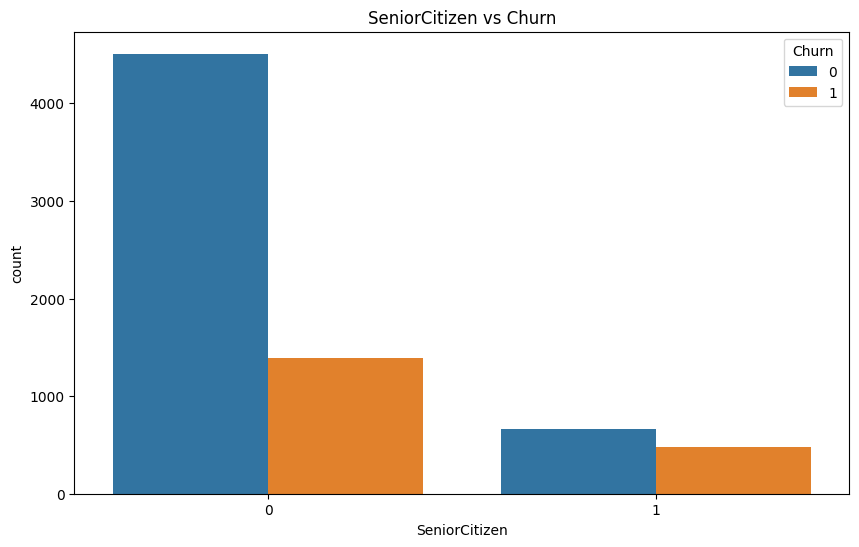

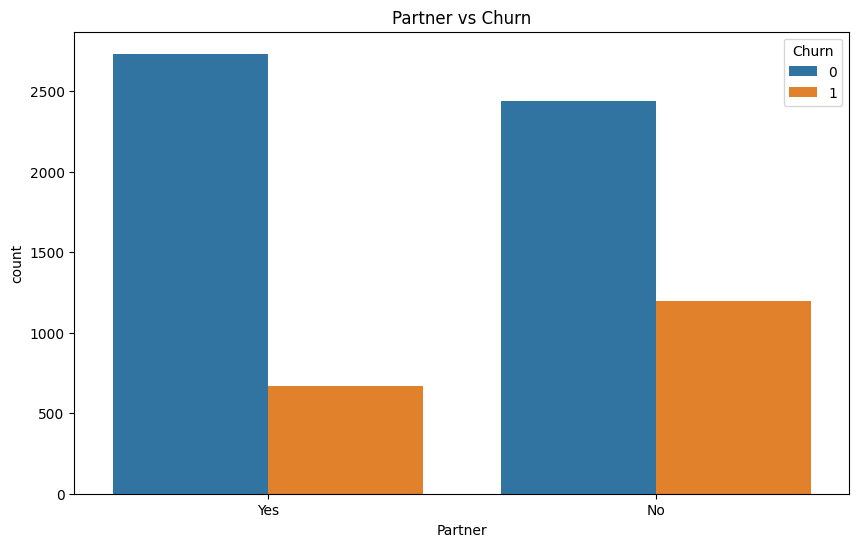

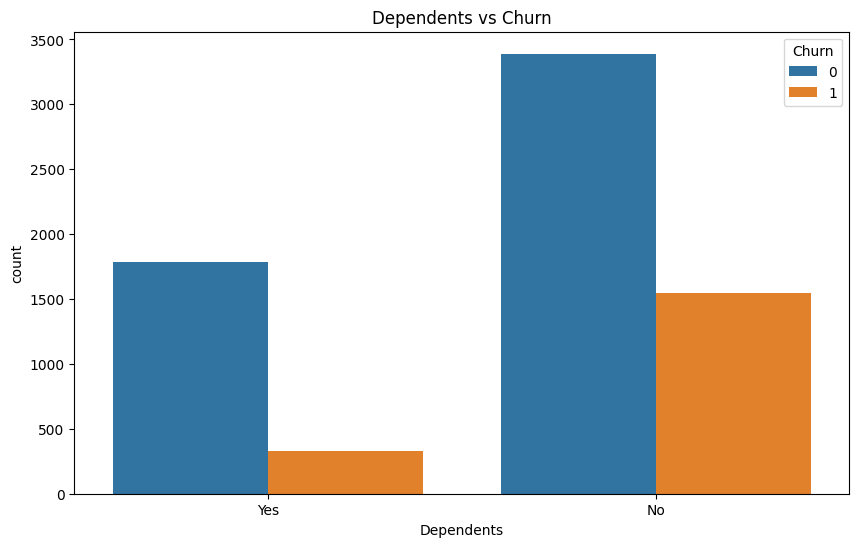

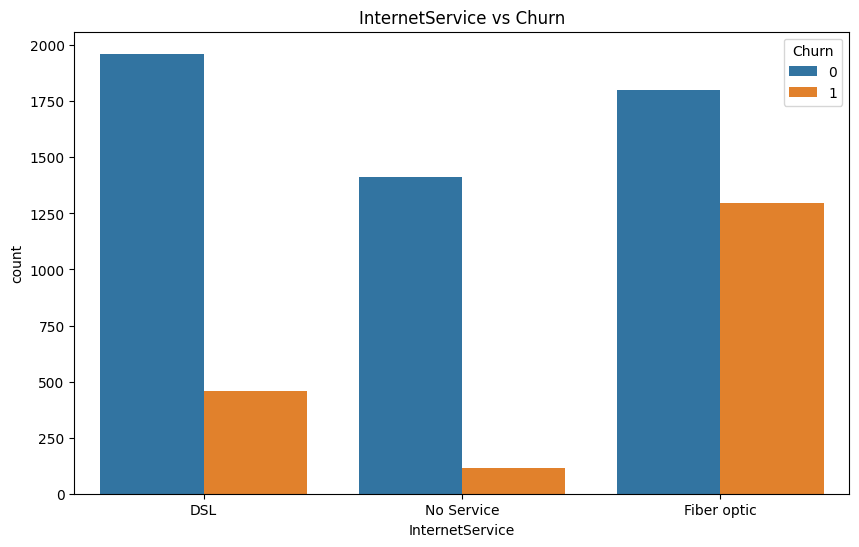

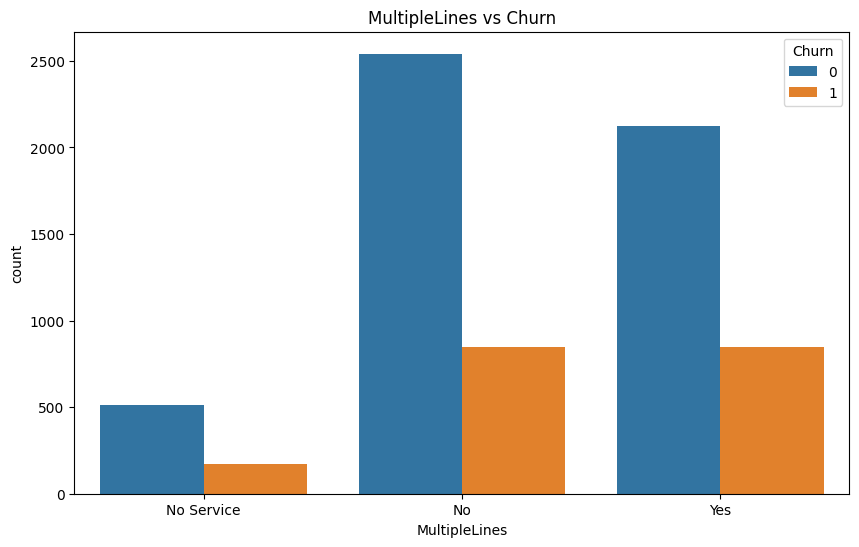

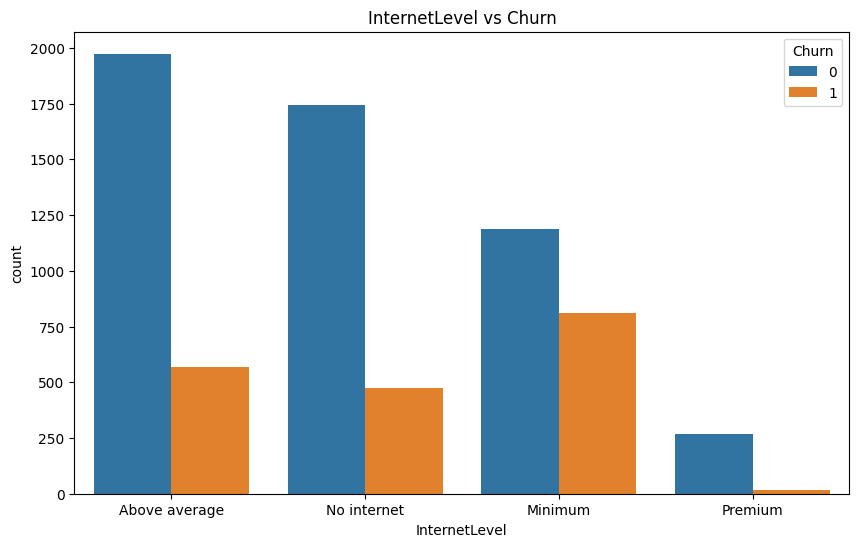

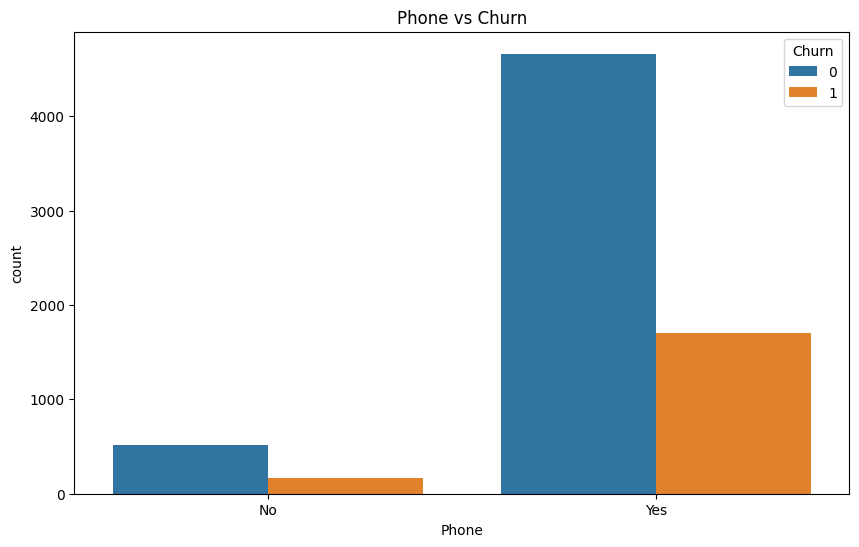

In [104]:
for feature in categorical_features:
    if feature != 'customerID':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=feature, hue='Churn', data=data)
        plt.title(f'{feature} vs Churn')
        plt.show()

- Тип оплаты существенно влияет на отток клиентов. Абоненты использующиеся помесячным типом намного более склонны к расторжению договора чем другие типы. Самый стабильный тип - оплата на два года.
- Электронный расчётный лист тоже влияет, но не так сильно. Более склонны к расторжению те кто пользуются электронным листом.
- Наблюдаем сильное влияние типа оплаты, а именно оплата электронным чеком. В этом случае очень часто встречается разрыв договора. Остальные типы оплаты более стабильны.
- Пол не влияет на расторжение договора.
- Брак не сильно влиет. Абоненты не находящиеся в браке немного более склонны к расторжению.
- Наличие детей может влиять на расторжение. При отсутсвии детей больше вероятность расторжения.
- Абоненты поключенные к DSL интернету или не поключенные к нему не склонны к расторжению договора, в отличии от пользователей пользующихся оптоволокном.
- Подключающие услуги связанные с интеренетом,  менее склонны к разрыву договора.

Можем сделать вывод что наиболее склонный к разрыву доровора абонент который подключает только оптоволоконный интернет без телефонной связи, без дополнительных услуг, с помесячной оплатой. Так же он не состоит в браке и не имеет детей.

Посмотрим на матрицу корреляции.

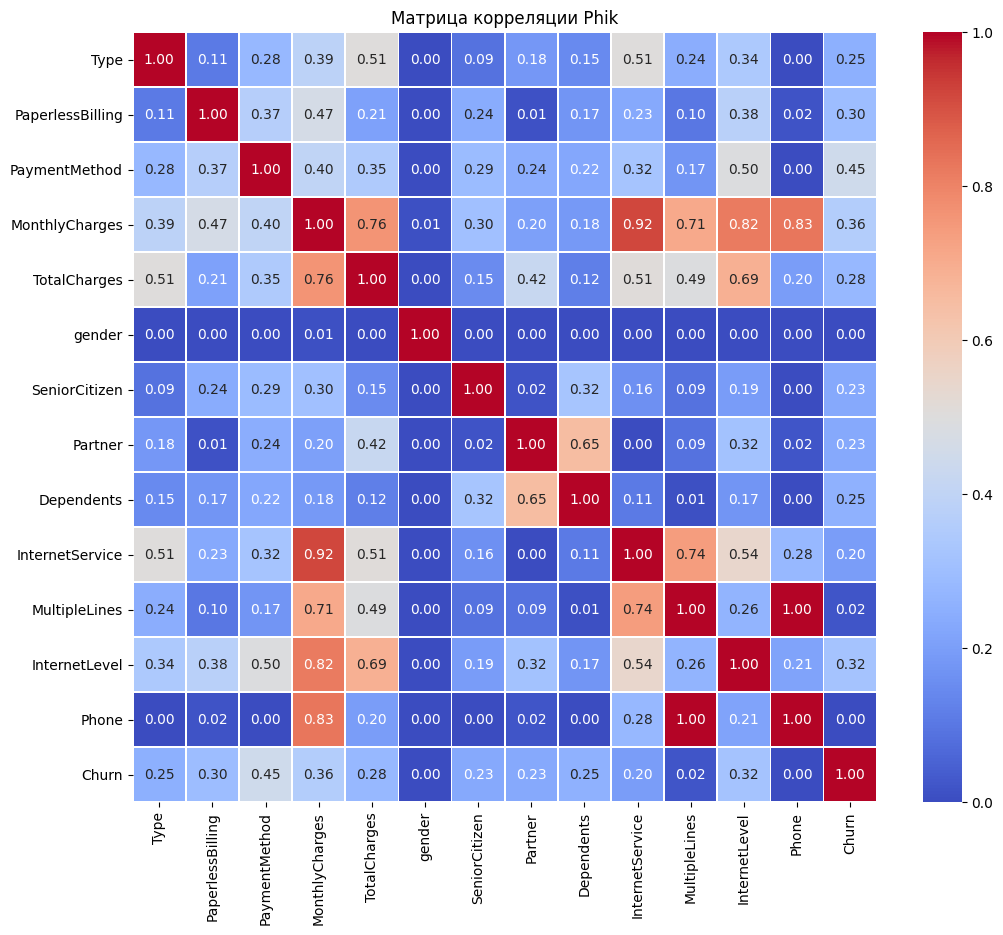

In [105]:
numerical_features = ['MonthlyCharges', 'TotalCharges']
data_without_customerID = data.drop(columns=['customerID'], errors='ignore')
phik_matrix = data_without_customerID.phik_matrix(interval_cols=numerical_features)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции Phik')
plt.show()

Присутсвует корреляция между двумя признаками: расходы за месяц и за всё время. Удалим расходы за месяц, будем использовать в дальнейшем только за всё время.

In [106]:
data = data.drop(['MonthlyCharges'], axis=1).reset_index(drop=True)

Посмотрели на визуализации, теперь удалим не нужные признаки. У нас только 1 стобец остался который нам не понадобится для обучения модели **customerID**, удалим его.

In [107]:
data = data.drop(['customerID'], axis=1).reset_index(drop=True)

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   TotalCharges      7043 non-null   float32
 4   gender            7043 non-null   object 
 5   SeniorCitizen     7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   MultipleLines     7043 non-null   object 
 10  InternetLevel     7043 non-null   object 
 11  Phone             7043 non-null   object 
 12  Churn             7043 non-null   int8   
dtypes: float32(1), int8(1), object(11)
memory usage: 639.8+ KB


Датасет для работы с моделями готов.

<a id='visual_conclusion'></a>
### Выводы по предобработке и анализу

Рассмотренные ранее таблицы объединили в один датасет. Закончили работу с пропусками. Добавили нескольно новых признаков: факт подключения у абонента интернета и стационарной связи, а так же колличество дней которое абонент пользуется или пользовался услугами. Выделили целевой признак **Churn** из даты окончания договора. Визуализировали признаки и их зависимость с целевым признаком. Нашли кореляцию между двумя признаками которые могут плохо сказаться на моделе, удалили один из них **TotalCharges**. По визуализациям сделали выводы выше. В кратце: наиболее склонный к разрыву доровора абонент который подключает только оптоволоконный интернет без телефонной связи, без дополнительных услуг, с помесячной оплатой. Так же он не состоит в браке и не имеет детей. Так же детальные выводы были сделаны выше в пункте до объединения таблиц. Данные подготовили к работе с моделями машинного обучения.

<a id='models'></a>
## Работа с моделями

Рассмотрим несколько моделей: Случайный лес, Catboost и полносвязную нейронную сеть. Для начала нам нужно подготовить выборки для обучения и тестирования.
<a id='features'></a>
### Подготовка признаков

Выделим целевой признак.

In [109]:
features = data.drop('Churn', axis=1)
target = data['Churn']

Получили 2 датасета:
- С признаками.
- С целевым признаком.

Произведём разделение на выборки в соотношении 75%/25% - тренировочная и тестовая соответсвенно.

In [110]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [111]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 12)
(1761, 12)
(5282,)
(1761,)


Разделение произвели, размеры проверили, всё корректно.

Произведём кодирование категориальных признаков с помощью порядкового кодирования (Ordinal Encoder).

In [112]:
categorical = features_train.select_dtypes(include=['object']).columns.to_list()
numeric = features_train.select_dtypes(include=['float32']).columns.to_list()

In [113]:
oe_train = features_train.copy()
oe_test = features_test.copy()

In [114]:
oe_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_encoder.fit(oe_train[categorical])

oe_train[oe_encoder.get_feature_names_out()] = oe_encoder.transform(oe_train[categorical])

oe_test[oe_encoder.get_feature_names_out()] = oe_encoder.transform(oe_test[categorical])

Кодирование выполнили. Сделаем масштабирование признаков.

In [117]:
oe_scaler = StandardScaler()
oe_train[numeric] = oe_scaler.fit_transform(oe_train[numeric])
oe_test[numeric] = oe_scaler.transform(oe_test[numeric])

Сделали масштабирование. Получили необходимые выборки и приготовили их для использования в моделях.

<a id='dummy'></a>
### Dummy Classifier

Посмотрим какие мы результаты получим "предсказывая" всегда само часто встречающееся значение.

In [118]:
dummy = DummyClassifier(random_state=RANDOM_STATE, strategy="most_frequent")
dummy.fit(oe_train, target_train)
dummy_predicted_train = dummy.predict(oe_train)

roc_auc = roc_auc_score(target_train, dummy_predicted_train)
accuracy = accuracy_score(target_train, dummy_predicted_train)

print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

ROC-AUC: 0.5
Accuracy: 0.7317304051495646


Получили ROC-AUC = 0.5 и Accuracy = 0.73.

<a id='rf'></a>
### Случайный лес

Обучим случайный лес на тренировочных данных и подберём параметры с помощью кросс-валидации.

In [119]:
n_estimators = list(range(100, 251, 20))
max_depth = list(range(3, 12, 2))
class_weight = [None, 'balanced']

print(n_estimators)
print(max_depth)
print(class_weight)

[100, 120, 140, 160, 180, 200, 220, 240]
[3, 5, 7, 9, 11]
[None, 'balanced']


In [120]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

params = {
          'n_estimators': n_estimators,
          'max_depth': max_depth,
          'class_weight': class_weight,
         }

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model_cv = GridSearchCV(estimator = rf_model, 
                           param_grid = params, 
                           scoring= 'roc_auc', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)

rf_model_cv.fit(oe_train, target_train)

best_rf_params = rf_model_cv.best_params_
best_rf_model = rf_model_cv.best_estimator_

print("Best Parameters:", best_rf_params, '\n')
print('ROC-AUC on training data: ', rf_model_cv.best_score_, '\n')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 160} 

ROC-AUC on training data:  0.8356298171916261 

CPU times: total: 2min 58s
Wall time: 2min 58s


Параметры для случайног леса подобрали, на кросс-валидации ROC-AUC = 0.836.

<a id='catboost'></a>
### Catboost

Обучим модель градиентного бустинга Catboost на тренировочных данных и подберём параметры с помощью кросс-валидации.

In [121]:
%%time

folds = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

param_grid = {
              'learning_rate': [0.1, 0.2, 0.3],
              'iterations': [10, 100, 1000]
             }

catboost_model = CatBoostClassifier(random_state=RANDOM_STATE,
                                    verbose=False,
                                    loss_function='Logloss')

catboost_model_cv = GridSearchCV(estimator=catboost_model,
                                 param_grid=param_grid,
                                 scoring='roc_auc',
                                 cv=folds,
                                 verbose = 1,
                                 return_train_score=True)

catboost_model_cv.fit(oe_train, target_train)

best_params = catboost_model_cv.best_params_
best_cat_model = catboost_model_cv.best_estimator_

print("Best Parameters:", best_params, '\n')
print('ROC-AUC on training data: ', catboost_model_cv.best_score_, '\n')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'iterations': 10, 'learning_rate': 0.3} 

ROC-AUC on training data:  0.8386712939643598 

CPU times: total: 7min 59s
Wall time: 33.8 s


Получили ROC-AUC = 0.839

<a id='net'></a>
### Нейронная сеть

Обучим полносвязную. нейронную сеть на тренировочных данных и подберём параметры с помощью кросс-валидации.

In [122]:
%%time

tf.random.set_seed(RANDOM_STATE)

def create_nn_model(input_dim, learning_rate):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
    return model

folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    'epochs': [10, 20, 30, 50, 100],
    'batch_size': [16, 32, 64, 128]
}

input_dim = oe_train.shape[1]
learning_rate = 0.0001

nn_model = KerasClassifier(model=create_nn_model, input_dim=input_dim, learning_rate=learning_rate, verbose=0)

nn_model_cv = GridSearchCV(estimator=nn_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

nn_model_cv.fit(oe_train, target_train)

best_params_nn = nn_model_cv.best_params_
best_nn_model = nn_model_cv.best_estimator_

print("Best Parameters:", best_params_nn, '\n')
print('ROC-AUC on training data: ', nn_model_cv.best_score_, '\n')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'batch_size': 64, 'epochs': 20} 

ROC-AUC on training data:  0.8302306563196874 

CPU times: total: 10min 43s
Wall time: 6min 33s


Получили ROC-AUC = 0.830

<a id='models_conclusion'></a>
### Выводы по обучению моделей

Сделали разбитие данных на выборки в соотношении 75%/25%. Провели прямое кодирование категориальных признаков и масштабирование. Обучили три модели: Случайный лес, Catboost и полносвязную нейронную сеть. Подбор гиперпараметров выполняли с помощью GridSearchCV. Лучший результат показал Catboost - ROC-AUC = 0.837. Остановимся на этой модели и посмотрим как она покажет себя на тестовой выборке.

<a id='test'></a>
## Тестирование модели

Протестируем Catboost модель на тестовых данных.

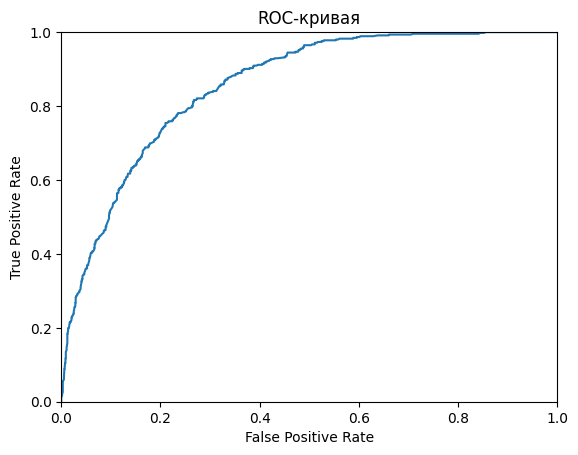

ROC-AUC на тестовой выборке: 0.8539899065016192
Accuracy: 0.8023850085178875


In [123]:
probabilities_test = best_cat_model.predict_proba(oe_test)
probabilities_one_test = probabilities_test[:, 1]
predictions = best_cat_model.predict(oe_test)
accuracy = accuracy_score(target_test, predictions)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('ROC-AUC на тестовой выборке:', auc_roc_test)
print('Accuracy:', accuracy)

Получили ROC-AUC = 0.854 и Accuracy = 0.802 на тестовых данных. Значение accuracy нам говорит о том что 80% всех предсказаний на тестовом датасете были правильными. Данное значение roc-auc показывает на то что модель хорошо способна разделять классы.

In [124]:
conf_matrix = confusion_matrix(target_test, predictions)

print('Матрица ошибок:', '\n' , conf_matrix)

Матрица ошибок: 
 [[1182  127]
 [ 221  231]]


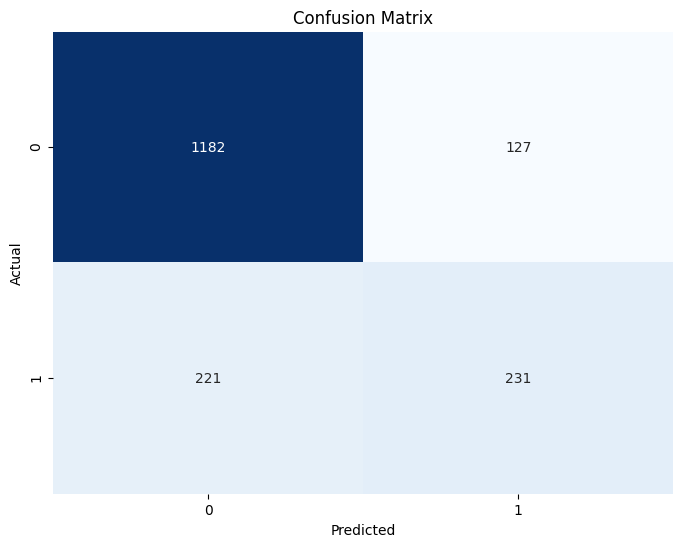

In [125]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Модель в 1182 случаях корректно смогла предсказать 0 класс (клиенты которые не ушли), данные значения называются истинно негативными (True Negative). В 221 случаях она сделала ошибку предсказав 0 класс, в то время когда в действительность клиент разорвал договор, данные значения называются ложно негативными (False Negative). В 231 случае модель корректно предсказала клиентов которые уйдут (1 класс), данные значения называются истинно позитивными (True Positive). И в 127 случае модель ошибочно предположила что клиент уйдёт (1 класс) в то время как он остался (0 класс). В итоге модель ошиблась в 348 случаях и правильные предсказания сделала в 1413 случаях, данные значения называются ложно позитивными (False Positive).

In [126]:
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)

print('Точность:', precision)
print('Полнота:', recall)

Точность: 0.6452513966480447
Полнота: 0.5110619469026548


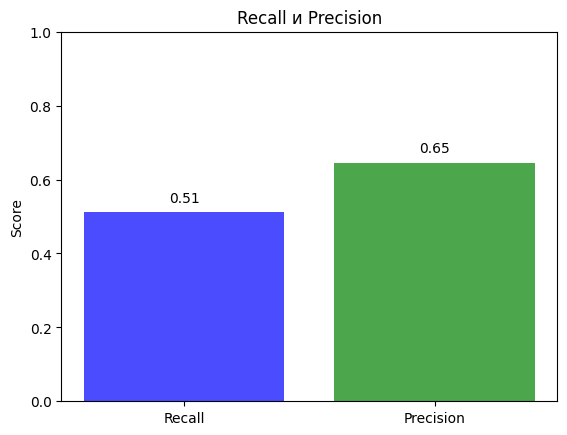

In [127]:
labels = ['Recall', 'Precision']
values = [recall, precision]

x = np.arange(len(labels))

plt.bar(x, values, align='center', alpha=0.7, color=['blue', 'green'])
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Recall и Precision')

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

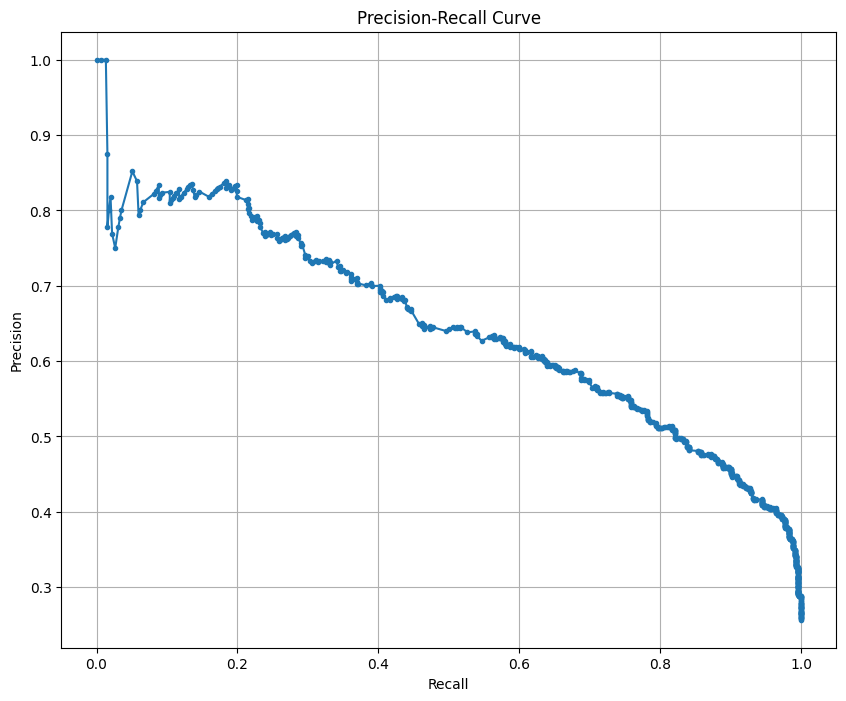

In [128]:
probas_pred = best_cat_model.predict_proba(oe_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, probas_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Точность показывает как много из предсказанных моделью положительных случаев действительно являются положительными. Мы получили 0.65 что значит что в 65% значения которые модель предсказала как положительные, действительно являются положительными.
Полнота измеряет, как много положительных случаев из всех действительных положительных случаев модель смогла обнаружить. Значение получили 0.51, значит модель смогла обнаружить около 51% всех действительных положительных случаев. Можем сделать вывод что модель старается избегать ложных положительных предсказаний. Это может быть полезно если запланированные методы удержания клиента дорогостоящие. Если бы модель часто предсказывала что клиент уйдёт, и руководствуясь этими данными были реализованы механизмы удержания клиентов которые и не собирались уходить, компания бы теряла деньги удерживая клиентов которые и не собирались уходить.

Посмотрим на важность признаков для предсказания.

In [129]:
importances = pd.DataFrame(best_cat_model.feature_importances_, index = oe_test.columns, columns=['importances'])
importances = importances.sort_values(by='importances', ascending=False)
importances

,importances
InternetService,31.00
Type,26.47
TotalCharges,18.65
PaymentMethod,8.98
PaperlessBilling,5.46
MultipleLines,5.35
InternetLevel,2.52
gender,0.86
SeniorCitizen,0.72
Partner,0.00


Самыми важными признаками являются, тип оплаты, общие расходы и тип поключения интернета или его отсутсвие. Посмотрим на графики зависимости для некоторых из них.

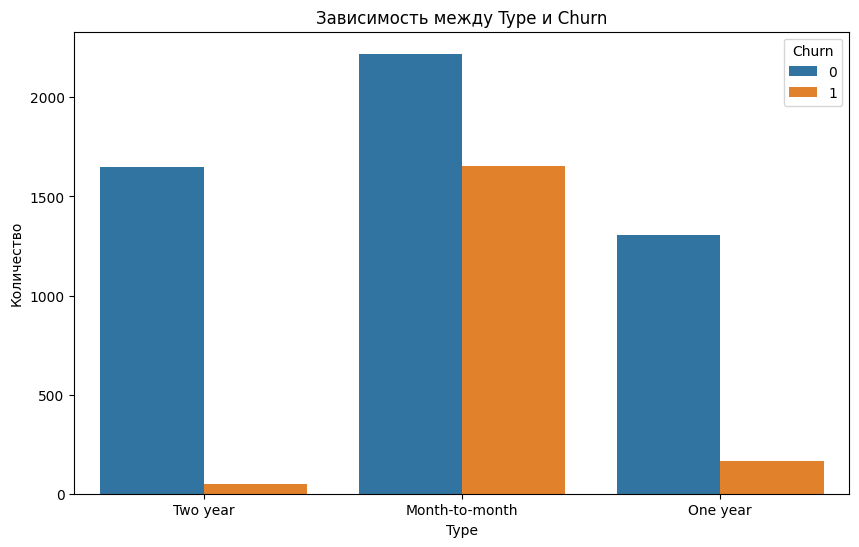

In [130]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', hue='Churn', data=data)
plt.title('Зависимость между Type и Churn')
plt.xlabel('Type')
plt.ylabel('Количество')
plt.show()

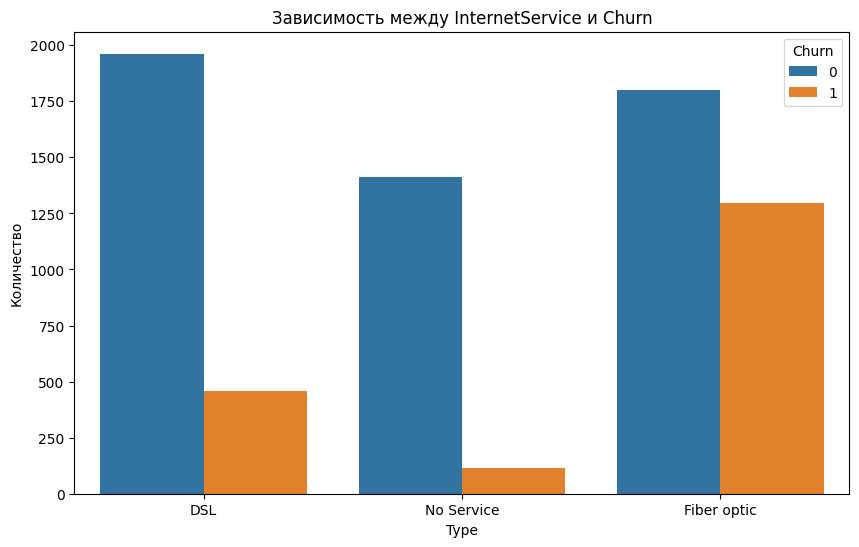

In [131]:
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=data)
plt.title('Зависимость между InternetService и Churn')
plt.xlabel('Type')
plt.ylabel('Количество')
plt.show()

Как мы выяснили ранее, если абонент имеет тип оплаты раз в два года, то крайне маловероятно что он разорвёт договор, в то время как с помесячной оплатой вероятность такого намного больше. В зависимости интернта на целевой признак видим что абоненты без интернета как правило не разрывают договор, а с оптоволокном имеют высокую вероятность разрыва договора.

<a id='conclusion'></a>
## Выводы

Нам нужно было создать модель которая сможет предсказать отток клиентов оператора связи, для того чтобы попытаться удержать их. На предоставили данные пользователей на 1 февраля 2020 года. Изучили данные и сделали предобработку. Подготовили данные для использования моделями машинного обучения. Обучили несколько моделей: Случайной Лес, Catboost и нейронную сеть. На обучающих данных Catboost показал лучший результат, протестировали эту модель на тестовой выборке. Нам нужно было достичь ROC-AUC метрики 0.85 чтобы модель считать успешной. Нам удалось достичь 0.854 что немного превышает минимум. Изучили важность признаков. Наиболее важными признаками являются: тип оплаты, общие расходы и тип поключения интернета. Модель можно улучшить используя больший набор данных и больше признаков.